<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTSRB3] - Training monitoring
<!-- DESC --> Episode 3 : Monitoring, analysis and check points during a training session
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - **Understand** what happens during the **training** process
  - Implement **monitoring**, **backup** and **recovery** solutions
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  
Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

## What we're going to do :

 - Monitoring and understanding our model training 
 - Add recovery points
 - Analyze the results 
 - Restore and run recovery points

## Step 1 - Import and init
### 1.1 - Python stuffs

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import h5py

from sklearn.metrics import confusion_matrix
from skimage import io, transform, color

import matplotlib.pyplot as plt
import os, sys, time, random

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/GTSRB3.001'
datasets_dir = pwk.init('GTSRB3', run_dir)

**\*\* Overrided parameters : \*\***

run_dir              : ./run/GTSRB3_done


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.17
Notebook id          : GTSRB3
Run time             : Monday 01 March 2021, 18:48:54
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/GTSRB3_done
Update keras cache   : False
Save figs            : True
Path figs            : ./run/GTSRB3_done/figs


### 1.2 - Parameters
`scale` is the proportion of the dataset that will be used during the training. (1 mean 100%)  
A 24x24 dataset, with 5 epochs and a scale of 1, need  3'30 on a CPU laptop.

In [2]:
enhanced_dir = './data'
# enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'

dataset_name = 'set-24x24-L'
batch_size   = 64
epochs       = 10
scale        = 1



Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('enhanced_dir', 'dataset_name', 'batch_size', 'epochs', 'scale')

**\*\* Overrided parameters : \*\***

enhanced_dir         : /gpfswork/rech/mlh/uja62cb/datasets/GTSRB/enhanced
dataset_name         : set-24x24-L
batch_size           : 64
epochs               : 5
scale                : 1


## Step 2 - Load dataset
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use a smart dataset : **set-24x24-L**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [4]:
def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    x_train,y_train, x_test,y_test data, x_meta,y_meta'''
    # ---- Read dataset
    pwk.chrono_start()
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]
    print(x_train.shape, y_train.shape)
    # ---- Shuffle
    x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

    # ---- done
    duration = pwk.chrono_stop(hdelay=True)
    size     = pwk.hsize(os.path.getsize(filename))
    print(f'Dataset "{dataset_name}" is loaded and shuffled. ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- Read dataset
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)

# ---- Rescale 
#
x_train,y_train, x_test,y_test = pwk.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

(39209, 24, 24, 1) (39209,)


Dataset "set-24x24-L" is loaded and shuffled. (228.8 Mo in 00:00:00 452ms)


## Step 3 - Have a look to the dataset
Note: Data must be reshape for matplotlib

x_train :  (39209, 24, 24, 1)
y_train :  (39209,)
x_test  :  (12630, 24, 24, 1)
y_test  :  (12630,)


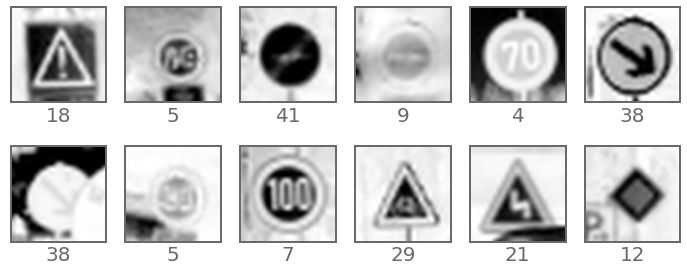

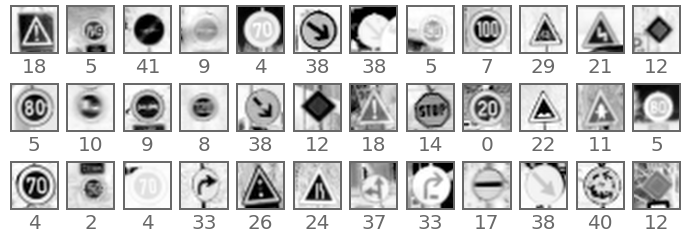

In [5]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

pwk.plot_images(x_train, y_train, range(12), columns=6,  x_size=2, y_size=2, save_as='01-dataset-medium')
pwk.plot_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1, save_as='02-dataset-small')

## Step 4 - Create model
We will now build a model and train it...

Some models... 

In [6]:
# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


## Step 5 - Prepare callbacks  
We will add 2 callbacks :  

**TensorBoard**  
Training logs, which can be visualised using [Tensorboard tool](https://www.tensorflow.org/tensorboard).  

**Model backup**  
 It is possible to save the model each xx epoch or at each improvement.  
 The model can be saved completely or partially (weight).  
 For full format, we can use HDF5 format.

In [7]:
pwk.mkdir(run_dir + '/models')
pwk.mkdir(run_dir + '/logs')

# ---- Callback tensorboard
log_dir = run_dir + "/logs/tb_" + pwk.tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = run_dir + "/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = run_dir + "/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

path=os.path.abspath(f'{run_dir}/logs')
print(f'To run tensorboard :\ntensorboard --logdir {path}')

To run tensorboard :
tensorboard --logdir /gpfsdswork/projects/rech/mlh/uja62cb/fidle/GTSRB/run/GTSRB3_done/logs


## Step 6 - Train the model
**Get the shape of my data :**

In [8]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [9]:
model = get_model_v1(lx,ly,lz)

# model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train it :**  
Note: The training curve is visible in real time with Tensorboard (see step  5)

In [10]:
pwk.chrono_start()

# ---- Shuffle train data
x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

# ---- Train
# Note: To be faster in our example, we can take only 2000 values
#
history = model.fit(  x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save(f'{run_dir}/models/last-model.h5')

pwk.chrono_show()

Epoch 1/5


  1/613 [..............................] - ETA: 31:38 - loss: 3.7629 - accuracy: 0.0156

  3/613 [..............................] - ETA: 53s - loss: 3.7349 - accuracy: 0.0321  

 21/613 [>.............................] - ETA: 6s - loss: 3.6315 - accuracy: 0.0393 

 39/613 [>.............................] - ETA: 4s - loss: 3.6103 - accuracy: 0.0443

 57/613 [=>............................] - ETA: 3s - loss: 3.5882 - accuracy: 0.0496

 75/613 [==>...........................] - ETA: 2s - loss: 3.5650 - accuracy: 0.0559

 93/613 [===>..........................] - ETA: 2s - loss: 3.5334 - accuracy: 0.0652

112/613 [====>.........................] - ETA: 2s - loss: 3.4872 - accuracy: 0.0782

131/613 [=====>........................] - ETA: 1s - loss: 3.4313 - accuracy: 0.0933

150/613 [======>.......................] - ETA: 1s - loss: 3.3684 - accuracy: 0.1099

169/613 [=======>......................] - ETA: 1s - loss: 3.3013 - accuracy: 0.1269

188/613 [========>.....................] - ETA: 1s - loss: 3.2329 - accuracy: 0.1441

207/613 [=========>....................] - ETA: 1s - loss: 3.1644 - accuracy: 0.1611

226/613 [==========>...................] - ETA: 1s - loss: 3.0971 - accuracy: 0.1778

245/613 [==========>...................] - ETA: 1s - loss: 3.0318 - accuracy: 0.1940

264/613 [===========>..................] - ETA: 1s - loss: 2.9688 - accuracy: 0.2096

283/613 [============>.................] - ETA: 1s - loss: 2.9082 - accuracy: 0.2247

302/613 [=============>................] - ETA: 1s - loss: 2.8500 - accuracy: 0.2392

321/613 [==============>...............] - ETA: 0s - loss: 2.7940 - accuracy: 0.2533

340/613 [===============>..............] - ETA: 0s - loss: 2.7404 - accuracy: 0.2669

359/613 [================>.............] - ETA: 0s - loss: 2.6890 - accuracy: 0.2799

378/613 [=================>............] - ETA: 0s - loss: 2.6396 - accuracy: 0.2925

397/613 [==================>...........] - ETA: 0s - loss: 2.5923 - accuracy: 0.3046

416/613 [===================>..........] - ETA: 0s - loss: 2.5470 - accuracy: 0.3163

435/613 [====================>.........] - ETA: 0s - loss: 2.5034 - accuracy: 0.3275

453/613 [=====================>........] - ETA: 0s - loss: 2.4637 - accuracy: 0.3377

471/613 [======================>.......] - ETA: 0s - loss: 2.4255 - accuracy: 0.3476

489/613 [======================>.......] - ETA: 0s - loss: 2.3886 - accuracy: 0.3571

507/613 [=======================>......] - ETA: 0s - loss: 2.3531 - accuracy: 0.3663

525/613 [========================>.....] - ETA: 0s - loss: 2.3188 - accuracy: 0.3752

543/613 [=========================>....] - ETA: 0s - loss: 2.2857 - accuracy: 0.3838

561/613 [==========================>...] - ETA: 0s - loss: 2.2537 - accuracy: 0.3921

579/613 [===========================>..] - ETA: 0s - loss: 2.2228 - accuracy: 0.4002

597/613 [============================>.] - ETA: 0s - loss: 2.1929 - accuracy: 0.4080

613/613 [==============================] - ETA: 0s - loss: 2.1672 - accuracy: 0.4147

613/613 [==============================] - 6s 5ms/step - loss: 2.1656 - accuracy: 0.4151 - val_loss: 0.4663 - val_accuracy: 0.8804


Epoch 2/5
  1/613 [..............................] - ETA: 2s - loss: 0.2738 - accuracy: 0.9062

 18/613 [..............................] - ETA: 1s - loss: 0.2858 - accuracy: 0.9059

 36/613 [>.............................] - ETA: 1s - loss: 0.2847 - accuracy: 0.9072

 54/613 [=>............................] - ETA: 1s - loss: 0.2857 - accuracy: 0.9081

 72/613 [==>...........................] - ETA: 1s - loss: 0.2835 - accuracy: 0.9104

 90/613 [===>..........................] - ETA: 1s - loss: 0.2829 - accuracy: 0.9122

108/613 [====>.........................] - ETA: 1s - loss: 0.2818 - accuracy: 0.9136

125/613 [=====>........................] - ETA: 1s - loss: 0.2807 - accuracy: 0.9147

143/613 [=====>........................] - ETA: 1s - loss: 0.2794 - accuracy: 0.9156

161/613 [======>.......................] - ETA: 1s - loss: 0.2784 - accuracy: 0.9162

179/613 [=======>......................] - ETA: 1s - loss: 0.2773 - accuracy: 0.9167

197/613 [========>.....................] - ETA: 1s - loss: 0.2764 - accuracy: 0.9171

214/613 [=========>....................] - ETA: 1s - loss: 0.2757 - accuracy: 0.9175

232/613 [==========>...................] - ETA: 1s - loss: 0.2747 - accuracy: 0.9179

250/613 [===========>..................] - ETA: 1s - loss: 0.2735 - accuracy: 0.9184

268/613 [============>.................] - ETA: 1s - loss: 0.2723 - accuracy: 0.9188

286/613 [============>.................] - ETA: 0s - loss: 0.2712 - accuracy: 0.9193

305/613 [=============>................] - ETA: 0s - loss: 0.2700 - accuracy: 0.9197

324/613 [==============>...............] - ETA: 0s - loss: 0.2688 - accuracy: 0.9201

343/613 [===============>..............] - ETA: 0s - loss: 0.2677 - accuracy: 0.9205

362/613 [================>.............] - ETA: 0s - loss: 0.2666 - accuracy: 0.9209

381/613 [=================>............] - ETA: 0s - loss: 0.2656 - accuracy: 0.9213

400/613 [==================>...........] - ETA: 0s - loss: 0.2645 - accuracy: 0.9217

419/613 [===================>..........] - ETA: 0s - loss: 0.2634 - accuracy: 0.9220

438/613 [====================>.........] - ETA: 0s - loss: 0.2624 - accuracy: 0.9224

457/613 [=====================>........] - ETA: 0s - loss: 0.2613 - accuracy: 0.9228

476/613 [======================>.......] - ETA: 0s - loss: 0.2603 - accuracy: 0.9231

495/613 [=======================>......] - ETA: 0s - loss: 0.2593 - accuracy: 0.9235

514/613 [========================>.....] - ETA: 0s - loss: 0.2582 - accuracy: 0.9238

533/613 [=========================>....] - ETA: 0s - loss: 0.2571 - accuracy: 0.9242

552/613 [==========================>...] - ETA: 0s - loss: 0.2561 - accuracy: 0.9246

571/613 [==========================>...] - ETA: 0s - loss: 0.2550 - accuracy: 0.9249

590/613 [===========================>..] - ETA: 0s - loss: 0.2540 - accuracy: 0.9253

609/613 [============================>.] - ETA: 0s - loss: 0.2530 - accuracy: 0.9256

613/613 [==============================] - 2s 3ms/step - loss: 0.2527 - accuracy: 0.9257 - val_loss: 0.3143 - val_accuracy: 0.9187


Epoch 3/5
  1/613 [..............................] - ETA: 1s - loss: 0.0603 - accuracy: 0.9688

 20/613 [..............................] - ETA: 1s - loss: 0.1470 - accuracy: 0.9551

 39/613 [>.............................] - ETA: 1s - loss: 0.1426 - accuracy: 0.9584

 59/613 [=>............................] - ETA: 1s - loss: 0.1376 - accuracy: 0.9604

 78/613 [==>...........................] - ETA: 1s - loss: 0.1348 - accuracy: 0.9614

 98/613 [===>..........................] - ETA: 1s - loss: 0.1334 - accuracy: 0.9620

117/613 [====>.........................] - ETA: 1s - loss: 0.1333 - accuracy: 0.9620

136/613 [=====>........................] - ETA: 1s - loss: 0.1331 - accuracy: 0.9621

155/613 [======>.......................] - ETA: 1s - loss: 0.1328 - accuracy: 0.9623

174/613 [=======>......................] - ETA: 1s - loss: 0.1322 - accuracy: 0.9625

193/613 [========>.....................] - ETA: 1s - loss: 0.1320 - accuracy: 0.9627

212/613 [=========>....................] - ETA: 1s - loss: 0.1318 - accuracy: 0.9628

231/613 [==========>...................] - ETA: 1s - loss: 0.1318 - accuracy: 0.9628

250/613 [===========>..................] - ETA: 0s - loss: 0.1318 - accuracy: 0.9628

269/613 [============>.................] - ETA: 0s - loss: 0.1317 - accuracy: 0.9628

288/613 [=============>................] - ETA: 0s - loss: 0.1315 - accuracy: 0.9629

307/613 [==============>...............] - ETA: 0s - loss: 0.1314 - accuracy: 0.9629

326/613 [==============>...............] - ETA: 0s - loss: 0.1313 - accuracy: 0.9630

345/613 [===============>..............] - ETA: 0s - loss: 0.1312 - accuracy: 0.9630

364/613 [================>.............] - ETA: 0s - loss: 0.1311 - accuracy: 0.9631

383/613 [=================>............] - ETA: 0s - loss: 0.1310 - accuracy: 0.9631

402/613 [==================>...........] - ETA: 0s - loss: 0.1308 - accuracy: 0.9631

421/613 [===================>..........] - ETA: 0s - loss: 0.1307 - accuracy: 0.9631

441/613 [====================>.........] - ETA: 0s - loss: 0.1305 - accuracy: 0.9632

460/613 [=====================>........] - ETA: 0s - loss: 0.1303 - accuracy: 0.9632

479/613 [======================>.......] - ETA: 0s - loss: 0.1301 - accuracy: 0.9633

498/613 [=======================>......] - ETA: 0s - loss: 0.1299 - accuracy: 0.9633

517/613 [========================>.....] - ETA: 0s - loss: 0.1296 - accuracy: 0.9634

536/613 [=========================>....] - ETA: 0s - loss: 0.1294 - accuracy: 0.9635

556/613 [==========================>...] - ETA: 0s - loss: 0.1290 - accuracy: 0.9636

575/613 [===========================>..] - ETA: 0s - loss: 0.1287 - accuracy: 0.9636

594/613 [============================>.] - ETA: 0s - loss: 0.1285 - accuracy: 0.9637

613/613 [==============================] - 2s 3ms/step - loss: 0.1282 - accuracy: 0.9638 - val_loss: 0.3121 - val_accuracy: 0.9260


Epoch 4/5
  1/613 [..............................] - ETA: 2s - loss: 0.1169 - accuracy: 0.9844

 20/613 [..............................] - ETA: 1s - loss: 0.0984 - accuracy: 0.9703

 39/613 [>.............................] - ETA: 1s - loss: 0.0948 - accuracy: 0.9705

 58/613 [=>............................] - ETA: 1s - loss: 0.0912 - accuracy: 0.9715

 77/613 [==>...........................] - ETA: 1s - loss: 0.0885 - accuracy: 0.9724

 96/613 [===>..........................] - ETA: 1s - loss: 0.0878 - accuracy: 0.9728

115/613 [====>.........................] - ETA: 1s - loss: 0.0875 - accuracy: 0.9730

134/613 [=====>........................] - ETA: 1s - loss: 0.0877 - accuracy: 0.9731

153/613 [======>.......................] - ETA: 1s - loss: 0.0879 - accuracy: 0.9731

172/613 [=======>......................] - ETA: 1s - loss: 0.0879 - accuracy: 0.9732

191/613 [========>.....................] - ETA: 1s - loss: 0.0877 - accuracy: 0.9734

210/613 [=========>....................] - ETA: 1s - loss: 0.0875 - accuracy: 0.9735

229/613 [==========>...................] - ETA: 1s - loss: 0.0874 - accuracy: 0.9736

248/613 [===========>..................] - ETA: 0s - loss: 0.0873 - accuracy: 0.9737

267/613 [============>.................] - ETA: 0s - loss: 0.0872 - accuracy: 0.9737

286/613 [============>.................] - ETA: 0s - loss: 0.0871 - accuracy: 0.9737

305/613 [=============>................] - ETA: 0s - loss: 0.0871 - accuracy: 0.9737

324/613 [==============>...............] - ETA: 0s - loss: 0.0871 - accuracy: 0.9738

343/613 [===============>..............] - ETA: 0s - loss: 0.0871 - accuracy: 0.9738

362/613 [================>.............] - ETA: 0s - loss: 0.0870 - accuracy: 0.9738

381/613 [=================>............] - ETA: 0s - loss: 0.0870 - accuracy: 0.9739

400/613 [==================>...........] - ETA: 0s - loss: 0.0869 - accuracy: 0.9739

419/613 [===================>..........] - ETA: 0s - loss: 0.0869 - accuracy: 0.9739

438/613 [====================>.........] - ETA: 0s - loss: 0.0868 - accuracy: 0.9739

457/613 [=====================>........] - ETA: 0s - loss: 0.0868 - accuracy: 0.9739

476/613 [======================>.......] - ETA: 0s - loss: 0.0867 - accuracy: 0.9740

495/613 [=======================>......] - ETA: 0s - loss: 0.0866 - accuracy: 0.9740

514/613 [========================>.....] - ETA: 0s - loss: 0.0866 - accuracy: 0.9740

533/613 [=========================>....] - ETA: 0s - loss: 0.0865 - accuracy: 0.9740

552/613 [==========================>...] - ETA: 0s - loss: 0.0865 - accuracy: 0.9740

571/613 [==========================>...] - ETA: 0s - loss: 0.0864 - accuracy: 0.9740

590/613 [===========================>..] - ETA: 0s - loss: 0.0864 - accuracy: 0.9741

609/613 [============================>.] - ETA: 0s - loss: 0.0864 - accuracy: 0.9741

613/613 [==============================] - 2s 3ms/step - loss: 0.0864 - accuracy: 0.9741 - val_loss: 0.2334 - val_accuracy: 0.9437


Epoch 5/5
  1/613 [..............................] - ETA: 1s - loss: 0.0654 - accuracy: 0.9844

 20/613 [..............................] - ETA: 1s - loss: 0.0548 - accuracy: 0.9839

 39/613 [>.............................] - ETA: 1s - loss: 0.0593 - accuracy: 0.9816

 58/613 [=>............................] - ETA: 1s - loss: 0.0632 - accuracy: 0.9806

 77/613 [==>...........................] - ETA: 1s - loss: 0.0645 - accuracy: 0.9806

 96/613 [===>..........................] - ETA: 1s - loss: 0.0651 - accuracy: 0.9806

116/613 [====>.........................] - ETA: 1s - loss: 0.0654 - accuracy: 0.9806

136/613 [=====>........................] - ETA: 1s - loss: 0.0654 - accuracy: 0.9806

156/613 [======>.......................] - ETA: 1s - loss: 0.0654 - accuracy: 0.9806

174/613 [=======>......................] - ETA: 1s - loss: 0.0653 - accuracy: 0.9806

192/613 [========>.....................] - ETA: 1s - loss: 0.0651 - accuracy: 0.9806

210/613 [=========>....................] - ETA: 1s - loss: 0.0649 - accuracy: 0.9807

228/613 [==========>...................] - ETA: 1s - loss: 0.0647 - accuracy: 0.9807

246/613 [===========>..................] - ETA: 1s - loss: 0.0646 - accuracy: 0.9808

264/613 [===========>..................] - ETA: 0s - loss: 0.0644 - accuracy: 0.9808

282/613 [============>.................] - ETA: 0s - loss: 0.0643 - accuracy: 0.9808

300/613 [=============>................] - ETA: 0s - loss: 0.0642 - accuracy: 0.9809

318/613 [==============>...............] - ETA: 0s - loss: 0.0641 - accuracy: 0.9809

336/613 [===============>..............] - ETA: 0s - loss: 0.0641 - accuracy: 0.9809

354/613 [================>.............] - ETA: 0s - loss: 0.0641 - accuracy: 0.9809

372/613 [=================>............] - ETA: 0s - loss: 0.0640 - accuracy: 0.9810

390/613 [==================>...........] - ETA: 0s - loss: 0.0640 - accuracy: 0.9810

408/613 [==================>...........] - ETA: 0s - loss: 0.0639 - accuracy: 0.9811

426/613 [===================>..........] - ETA: 0s - loss: 0.0638 - accuracy: 0.9811

444/613 [====================>.........] - ETA: 0s - loss: 0.0637 - accuracy: 0.9812

462/613 [=====================>........] - ETA: 0s - loss: 0.0636 - accuracy: 0.9812

480/613 [======================>.......] - ETA: 0s - loss: 0.0634 - accuracy: 0.9813

498/613 [=======================>......] - ETA: 0s - loss: 0.0634 - accuracy: 0.9813

516/613 [========================>.....] - ETA: 0s - loss: 0.0633 - accuracy: 0.9813

534/613 [=========================>....] - ETA: 0s - loss: 0.0633 - accuracy: 0.9813

552/613 [==========================>...] - ETA: 0s - loss: 0.0632 - accuracy: 0.9813

570/613 [==========================>...] - ETA: 0s - loss: 0.0631 - accuracy: 0.9813

588/613 [===========================>..] - ETA: 0s - loss: 0.0631 - accuracy: 0.9814

606/613 [============================>.] - ETA: 0s - loss: 0.0630 - accuracy: 0.9814

613/613 [==============================] - 2s 3ms/step - loss: 0.0630 - accuracy: 0.9814 - val_loss: 0.2669 - val_accuracy: 0.9424



Duration :  00:00:18 355ms


**Evaluate it :**

In [11]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9437


In [12]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2669
Test accuracy  : 0.9424


## Step 7 - History
The return of model.fit() returns us the learning history

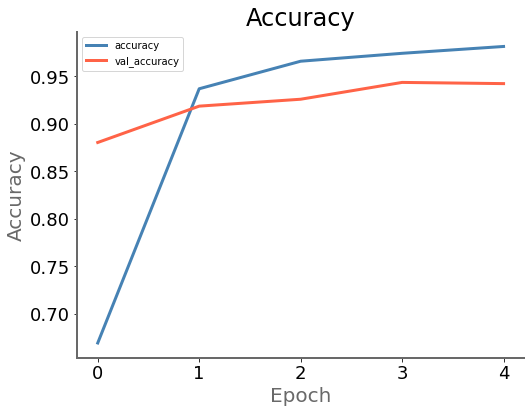

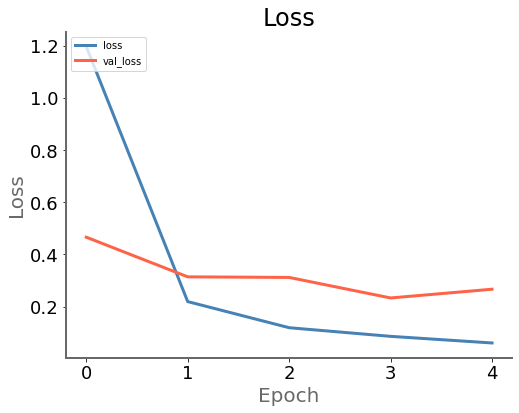

In [13]:
pwk.plot_history(history, save_as='03-history')

## Step 8 - Evaluation and confusion

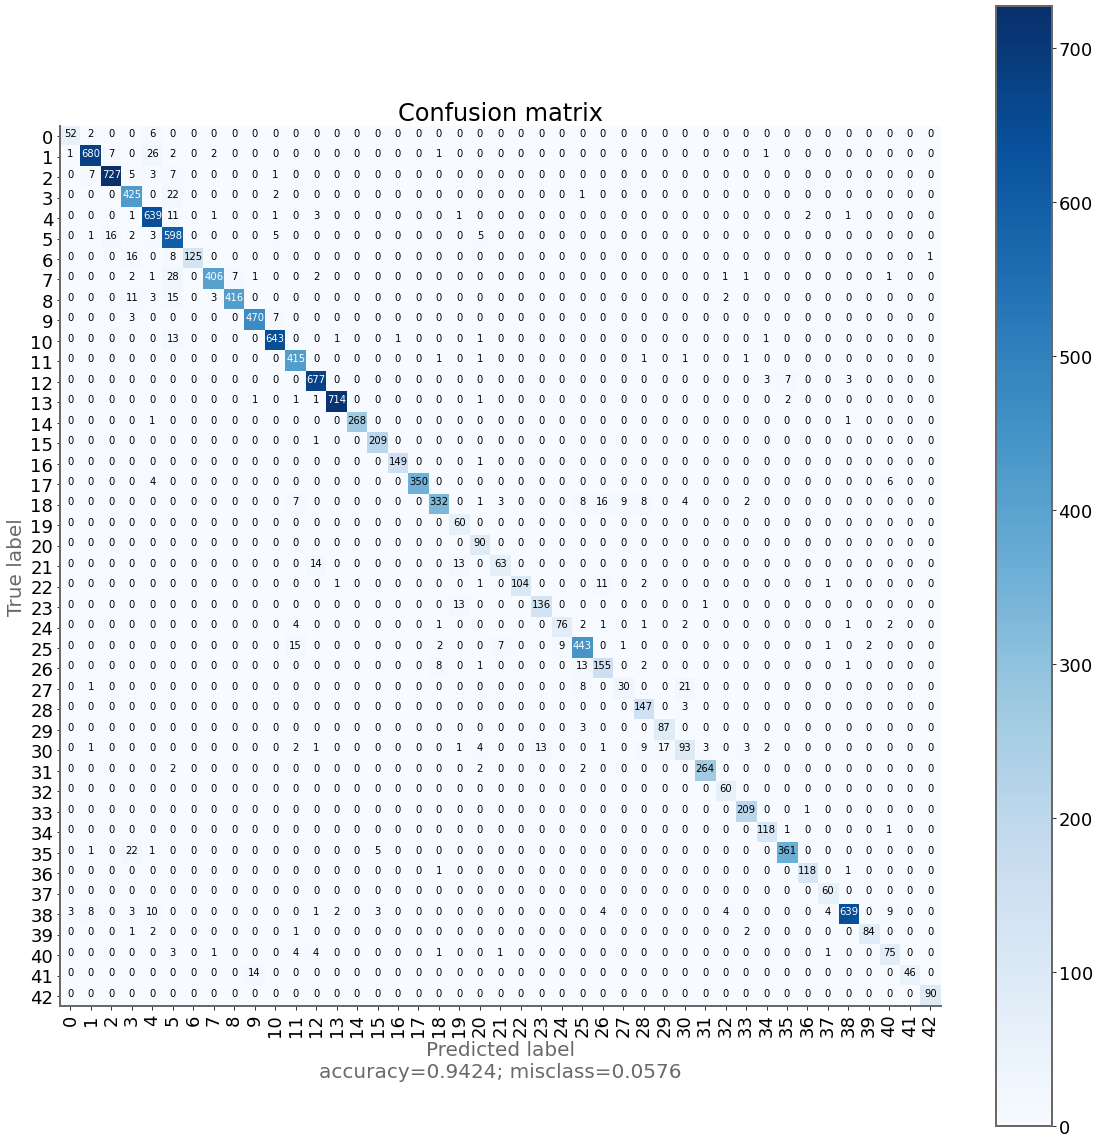

In [14]:
y_sigmoid = model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

pwk.plot_confusion_matrix(y_test,y_pred,range(43), figsize=(16, 16),normalize=False, save_as='04-confusion-matrix')

## Step 9 - Restore and evaluate
### 9.1 - List saved models :

In [15]:
!find "$run_dir"/models/

./run/GTSRB3_done/models/
./run/GTSRB3_done/models/last-model.h5
./run/GTSRB3_done/models/model-0002.h5
./run/GTSRB3_done/models/model-0004.h5
./run/GTSRB3_done/models/best-model.h5
./run/GTSRB3_done/models/model-0005.h5
./run/GTSRB3_done/models/model-0001.h5
./run/GTSRB3_done/models/model-0003.h5


### 9.2 - Restore a model :

In [16]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.h5')
# loaded_model.summary()
print("Loaded.")

Loaded.


### 9.3 - Evaluate it :

In [17]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2669
Test accuracy  : 0.9424


### 9.4 - Make a prediction :


Output layer from model is (x100) :

[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.23  0.    0.    0.    0.    0.    0.
   0.   99.77  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]

Graphically :



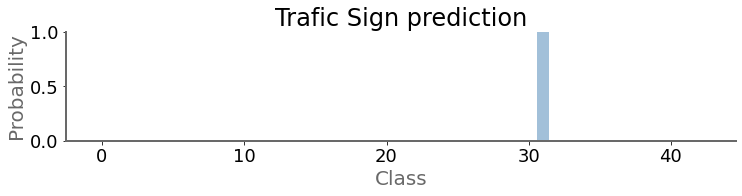


The image :               Prediction :            Real stuff:


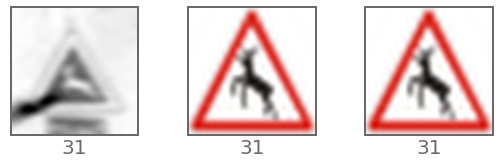

YEEES ! that's right!


In [18]:
# ---- Get a random image
#
i   = random.randint(1,len(x_test))
x,y = x_test[i], y_test[i]

# ---- Do prediction
#
predictions = loaded_model.predict( np.array([x]) )

# ---- A prediction is just the output layer
#
print("\nOutput layer from model is (x100) :\n")
with np.printoptions(precision=2, suppress=True, linewidth=95):
    print(predictions*100)

# ---- Graphic visualisation
#
print("\nGraphically :\n")
plt.figure(figsize=(12,2))
plt.bar(range(43), predictions[0], align='center', alpha=0.5)
plt.ylabel('Probability')
plt.ylim((0,1))
plt.xlabel('Class')
plt.title('Trafic Sign prediction')
pwk.save_fig('05-prediction-proba')
plt.show()

# ---- Predict class
#
p = np.argmax(predictions)

# ---- Show result
#
print("\nThe image :               Prediction :            Real stuff:")
pwk.plot_images([x,x_meta[p], x_meta[y]], [p,p,y], range(3),  columns=3,  x_size=3, y_size=2, save_as='06-prediction-images')

if p==y:
    print("YEEES ! that's right!")
else:
    print("oups, that's wrong ;-(")

In [19]:
pwk.end()

End time is : Monday 01 March 2021, 18:49:54
Duration is : 00:00:60 724ms
This notebook ends here


<div class="todo">
     What you can do:
    <ul>
        <li>Limit model saving: 1 save every 5 epochs </li>
        <li>Use a subset of the dataset</li>
        <li>Try different datasets</li>
        <li>Some exotic signs are waiting to be recognized in dataset_dir/extra !</li>
        <li>Test different hyperparameters (epochs, batch size, optimization, etc.)</li>
    </ul>
    
</div>

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>